In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import scipy.io
import matplotlib.gridspec as gridspec

from mpl_toolkits.basemap import Basemap
from spacepy import coordinates as coord
from spacepy.time import Ticktock as Ticktock

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 12
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [2]:
# Load coastlines:
import xflib
itime = datetime.datetime(2010,1,1,0,0,0)

# Convert the Matlab coastline datafile to geomagnetic coordinates:

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
coastlines = scipy.io.loadmat('coastlines.mat')
coast_lat_mag = np.zeros(len(coastlines['lat']))
coast_lon_mag = np.zeros(len(coastlines['long']))

for ind, (lat, lon) in enumerate(zip(coastlines['lat'], coastlines['long'])):
    if np.isnan(lat) or np.isnan(lon):
        coast_lat_mag[ind] = np.nan
        coast_lon_mag[ind] = np.nan
    else:
        tmpcoords = [1, lat[0], lon[0]]
        tmp_mag = xf.rllgeo2rllmag(tmpcoords, itime)
        coast_lat_mag[ind] = tmp_mag[1]
        coast_lon_mag[ind] = tmp_mag[2]

# Loop around for -180 + 180 ranges
coast_lat_mag = np.concatenate([coast_lat_mag, coast_lat_mag[coast_lon_mag > 180]])
coast_lon_mag = np.concatenate([coast_lon_mag, (coast_lon_mag[coast_lon_mag > 180] - 360)])

# Toss in some NaNs to break up the continents
for ind in range(len(coast_lat_mag) -1):
    if ((np.abs(coast_lat_mag[ind+1] - coast_lat_mag[ind]) > 5) or
       (np.abs(coast_lon_mag[ind+1] - coast_lon_mag[ind]) > 5)):
        coast_lat_mag[ind] = np.nan
        coast_lon_mag[ind] = np.nan

    
# fig, ax = plt.subplots(2,1)
# ax[0].plot(coast_lon_mag, coast_lat_mag, 'b')
# ax[0].plot(coastlines['long'],coastlines['lat'],'r')

In [3]:
# Load input energies (precalculated), convert to densities
inlats = [50, 35, 15]
mlts   = [0, 12]
rootdir ='/shared/users/asousa/WIPP/WIPP_stencils/'
power_dir    = os.path.join(rootdir,'outputs','input_energies_0.25deg')

R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.

I0 = 10000.
all_data = []
for inlat in inlats:
    for mlt in [0, 12]:
        fn = os.path.join(power_dir,'input_energy_%d_%d.pklz'%(inlat, mlt))
        print os.path.exists(fn)
        with gzip.open(fn,'rb') as file:
            data = pickle.load(file)
        
        
        # Get areas of each cell (for energy density)
        
        areas = np.zeros([len(data['clats']), len(data['clons'])])
        
        
        dlat = data['clats'][1] - data['clats'][0]
        dlon = data['clons'][1] - data['clons'][0] 
        
        # Get areas of each cell, in km:
        cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos(data['clats']*D2R))
        
        # Sum over frequencies:
        data['pwr'] = np.sum(data['pwr'], axis=0)
        data['pwr']*= pow(I0,2)  # scale by peak current
        data['pwr']/= cell_areas[:, np.newaxis] # Divide by area to get density
        data['pwr'] = np.hstack([np.fliplr(data['pwr'][:,:-1]), data['pwr']]) # Flip for both sides of flash
        
        x = data['clons']
        data['clons'] = np.hstack([x[:-1] - x[-1] + x[0], x])
        print np.shape(data['clons'])
        print np.shape(data['clats'])
        print np.shape(data['pwr'])
        all_data.append(data)


True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)


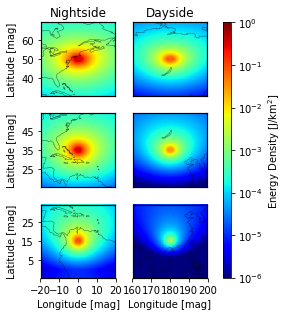

In [13]:
# Do a nice plot
# # --------------- Latex Plot Beautification --------------------------
# # defense slides formatting
# fig_width = 4.2 
# fig_height = 5
# fig_size =  [fig_width+1,fig_height+1]
# params = {'backend': 'ps',
#           'axes.labelsize': 14,
#           'font.size': 14,
#           'legend.fontsize': 14,
#           'xtick.labelsize': 12,
#           'ytick.labelsize': 12,
#           'text.usetex': False,
#           'figure.figsize': fig_size}
# plt.rcParams.update(params)
# # --------------- Latex Plot Beautification --------------------------



# --------------- Latex Plot Beautification --------------------------
# # printed dissertation formatting
fig_width = 3 
fig_height = 3.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fig = plt.figure()
gs = gridspec.GridSpec(len(inlats),3, width_ratios=[1,1,0.1])
print gs
ax = []

cmap = plt.get_cmap('jet')
clims = [-6,0]
for i in range(len(inlats)):
    ax.append(plt.subplot(gs[i,0]))
    ax.append(plt.subplot(gs[i,1]))
cbax = plt.subplot(gs[:,-1])


for i in range(2*len(inlats)):
    [j.set_linewidth(1.2) for j in ax[i].spines.itervalues()]  # Thick borders

    lats = all_data[i]['clats']
    lons = all_data[i]['clons']
    # Interpolate onto a smoother axis for plotting
    newlats = np.linspace(lats[0], lats[-1], 200)
    newlons = np.linspace(lons[0], lons[-1], 200)
    interp = interpolate.RegularGridInterpolator([lats, lons], np.log10(all_data[i]['pwr']))
    px, py = np.meshgrid(newlons, newlats)
    pts = zip(py.ravel(), px.ravel())
    D_interp = (interp(pts)).reshape(len(newlons), len(newlats))

    p = ax[i].pcolorfast(newlons, newlats, D_interp, cmap=cmap, vmin=clims[0], vmax=clims[1])
#     p = ax[i].pcolorfast(lons, lats, np.log10(all_data[i]['pwr']), cmap = cmap, vmin=clims[0], vmax=clims[1])
    ax[i].plot(coast_lon_mag, coast_lat_mag, 'k', linewidth=0.5, alpha=0.6)

    ax[i].set_xlim([lons[0], lons[-1]])
    ax[i].set_ylim([lats[0], lats[-1]])
    ax[i].set_aspect('equal')
    

cb = plt.colorbar(p, cax=cbax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy Density [J/km$^2$]')

ax = np.reshape(ax, [len(inlats),2])

for i in range(len(inlats)):
    ax[i,1].set_yticks([])
    ax[i,0].set_ylabel('Latitude [mag]')
    ax[i,0].set_yticks(np.arange(-1,2,1)*10 + inlats[i])
for i in range(len(inlats)-1):
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])

ax[0,0].set_title('Nightside')
ax[0,1].set_title('Dayside')
ax[-1,0].set_xlabel('Longitude [mag]')
ax[-1,1].set_xlabel('Longitude [mag]')
fig.tight_layout()

fig.savefig('illumination.png',dpi=300)

## For the thesis (with basemap to avoid distortion)

39.8711897331 288.746604928
60.1288102669 108.746604928
24.8711897331 288.746604928
45.1288102669 108.746604928
4.87118973306 288.746604928
25.1288102669 108.746604928


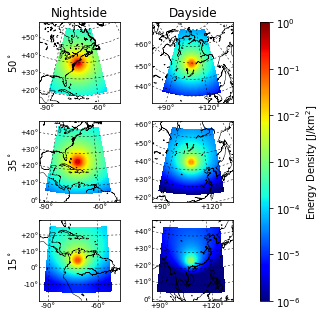

In [49]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 3.5 
fig_height = 3.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
def rotate_2d_to_geo(data):
    in_lats = all_data[i]['clats']
    in_lons = all_data[i]['clons']

    newlats = np.linspace(in_lats[0], in_lats[-1], 200)
    newlons = np.linspace(in_lons[0], in_lons[-1], 200)
    interp = interpolate.RegularGridInterpolator([in_lats, in_lons], np.log10(all_data[i]['pwr']))
    px, py = np.meshgrid(newlons, newlats)
    pts = zip(py.ravel(), px.ravel())
    flux = (interp(pts)).reshape(len(newlons), len(newlats))


    # flux = all_data[i]['pwr']
    lons, lats = np.meshgrid(newlons, newlats)
#     flashtime = datetime.datetime(2010,1,4,0,0,0)
    tmp_coords = coord.Coords(zip(np.ones_like(lats.ravel()), lats.ravel(), lons.ravel()),'MAG','sph',units=['Re','deg','deg'])
    tvec_datetime = [flashtime for s in lats.ravel()]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('GEO','sph')


    geo_lons = tmp_coords.long.reshape(np.shape(lats))
    geo_lats = tmp_coords.lati.reshape(np.shape(lats))
    
    return geo_lats, geo_lons, flux


flashtime = datetime.datetime(2010,1,4,0,0,0)


fig = plt.figure()
gs = gridspec.GridSpec(len(inlats),3, width_ratios=[1,1,0.1])

ax = []

cmap = plt.get_cmap('jet')
clims = [-6,0]
for i in range(len(inlats)):
    ax.append(plt.subplot(gs[i,0]))
    ax.append(plt.subplot(gs[i,1]))
cbax = plt.subplot(gs[:,-1])



for i in range(2*len(inlats)):
#     [j.set_linewidth(1.2) for j in ax[i].spines.itervalues()]  # Thick borders
    geo_lats, geo_lons, flux = rotate_2d_to_geo(all_data[i])
    clat_mag = all_data[i]['flash_lat']
    clon_mag = xf.MLT2lon(flashtime, all_data[i]['flash_mlt'])
    
    _, clat, clon = xf.rllmag2rllgeo([1, clat_mag, clon_mag], flashtime)
    print clat, clon
    h = 10000
    m = Basemap(ax=ax[i], projection='lcc', lon_0 = clon, lat_0 = clat, width=50*111*1e3, height = 50*111*1e3, resolution='l')

    m.drawcoastlines(linewidth=0.5,zorder=10)
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,120.,10.), labels=[True, False, False, False ], linewidth=0.5, fontsize=7, labelstyle='+/-')
    m.drawmeridians(np.arange(0.,420.,30.), labels = [False, False, False, True ], linewidth=0.5, fontsize=7, labelstyle='+/-')

    # Plot the data
    x, y = m(geo_lons, geo_lats)
    CS1 = m.pcolormesh(x,y,flux,cmap=plt.cm.jet, vmin=clims[0], vmax=clims[1])

cb = plt.colorbar(p, cax=cbax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy Density [J/km$^2$]')

ax = np.reshape(ax, [len(inlats),2])

# for i in range(len(inlats)):
#     ax[i,1].set_yticks([])
#     ax[i,0].set_ylabel('Latitude (deg)')
#     ax[i,0].set_yticks(np.arange(-1,2,1)*10 + inlats[i])
# for i in range(len(inlats)-1):
#     ax[i,0].set_xticks([])
#     ax[i,1].set_xticks([])

for i in range(len(inlats)):
    ax[i,0].set_ylabel('%d$^\circ$'%inlats[i], rotation=90, labelpad=20)

ax[0,0].set_title('Nightside')
ax[0,1].set_title('Dayside')
# ax[-1,0].set_xlabel('Longitude (deg)')
# ax[-1,1].set_xlabel('Longitude (deg)')
gs.tight_layout(fig, w_pad=3)
fig.subplots_adjust(left=-0.2)
fig.savefig('illumination_basemap.png',dpi=300)


In [45]:
fig.savefig('illumination_basemap.png',dpi=300)



In [52]:
# Plot total energy vs latitude, for a family of peak currents:
d = os.listdir(power_dir)
avail_lats = sorted(np.unique([int(i[0:-5].split('_')[2]) for i in d if i.endswith('.pklz')]))
avail_mlts = np.unique([int(i[0:-5].split('_')[3]) for i in d if i.endswith('.pklz')])
print avail_lats, avail_mlts

pwr_unscaled = np.zeros([len(avail_mlts),len(avail_lats)])

for mlt_ind, mlt in enumerate(avail_mlts):
    for lat_ind, lat in enumerate(avail_lats):

        fn = os.path.join(power_dir, 'input_energy_%g_%g.pklz'%(lat, mlt))

        with gzip.open(fn,'rb') as file:
            data = pickle.load(file)
        tot_energy = np.sum(data['pwr'])
        pwr_unscaled[mlt_ind, lat_ind] = tot_energy


[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54] [ 0 12]


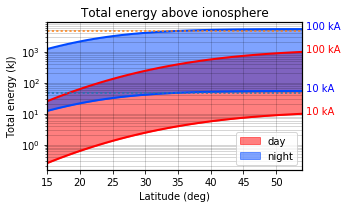

In [219]:
# Do a nice plot
import matplotlib.cm as cm

# # --------------- Latex Plot Beautification --------------------------
# ## Defense slides version
# fig_width = 3.75 
# fig_height = 2.25
# fig_size =  [fig_width+1,fig_height+1]
# params = {'backend': 'ps',
#           'axes.labelsize': 12,
#           'font.size': 12,
#           'legend.fontsize': 12,
#           'xtick.labelsize': 11,
#           'ytick.labelsize': 11,
#           'text.usetex': False,
#           'figure.figsize': fig_size}
# plt.rcParams.update(params)
# # --------------- Latex Plot Beautification --------------------------


# --------------- Latex Plot Beautification --------------------------
## Dissertation print version
fig_width = 4 
fig_height = 2
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
I0vec = np.array([10, 100]) # kA

pwr_day = np.outer(pwr_unscaled[1,:],pow(I0vec*1e3, 2))*1e-3
pwr_nite = np.outer(pwr_unscaled[0,:],pow(I0vec*1e3, 2))*1e-3

fig, ax = plt.subplots(1,1)

[j.set_linewidth(1.2) for j in ax.spines.itervalues()]  # Thick borders

daycolor = 'red'
nitecolor= cm.jet(50)#'blue'

ax.semilogy(avail_lats, pwr_day, linewidth=2, color=daycolor)
ax.semilogy(avail_lats, pwr_nite, linewidth=2, color=nitecolor)
ax.fill_between(avail_lats, pwr_day[:,0], pwr_day[:,1], color=daycolor, alpha=0.5, zorder=1, label='day')
ax.fill_between(avail_lats, pwr_nite[:,0], pwr_nite[:,1], color=nitecolor, alpha=0.5, zorder=1, label='night')

# total power (not just upgoing):

Zo = 377.
mu = 4.*np.pi*1e-7
a = 5*1e3
b = 1*1e5
H_E = 5000
i0 = -10e3
total_energy_10 = (1/Zo)*pow(mu/2./np.pi, 2)*(pow((a - b),2)/2/(a + b))* (4.*np.pi/3.)*pow(H_E*i0,2)*1e-3
i0 = -100e3
total_energy_100 = (1/Zo)*pow(mu/2./np.pi, 2)*(pow((a - b),2)/2/(a + b))* (4.*np.pi/3.)*pow(H_E*i0,2)*1e-3

ax.plot([0,90],[total_energy_10, total_energy_10],':')
ax.plot([0,90],[total_energy_100, total_energy_100],':')


ax.grid('on', which='both',linestyle='-', color='k', alpha=0.2)
ax.legend()
ax.set_xlim([15,54])
ax.text(avail_lats[-1] + 0.5, pwr_day[-1,1],"100 kA", color='r')
ax.text(avail_lats[-1] + 0.5, pwr_day[-1,0],"10 kA", color='r')
ax.text(avail_lats[-1] + 0.5, pwr_nite[-1,1],"100 kA", color='b')
ax.text(avail_lats[-1] + 0.5, pwr_nite[-1,0],"10 kA", color='b')

ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('Total energy (kJ)')
ax.set_title('Total energy above ionosphere')
fig.tight_layout()
plt.subplots_adjust(right=0.85)

# fig.savefig('total_energy.png', dpi=300)
fig.savefig('total_energy.pdf')


## Plot input power with grid

In [60]:
from mpl_toolkits.basemap import Basemap
from spacepy import coordinates as coord
from spacepy.time import Ticktock as Ticktock

i = 2
in_lats = all_data[i]['clats']
in_lons = all_data[i]['clons']

newlats = np.linspace(in_lats[0], in_lats[-1], 200)
newlons = np.linspace(in_lons[0], in_lons[-1], 200)
interp = interpolate.RegularGridInterpolator([in_lats, in_lons], np.log10(all_data[i]['pwr']))
px, py = np.meshgrid(newlons, newlats)
pts = zip(py.ravel(), px.ravel())
flux = (interp(pts)).reshape(len(newlons), len(newlats))


# flux = all_data[i]['pwr']
lons, lats = np.meshgrid(newlons, newlats)
flashtime = datetime.datetime(2010,1,4,0,0,0)
tmp_coords = coord.Coords(zip(np.ones_like(lats.ravel()), lats.ravel(), lons.ravel()),'MAG','sph',units=['Re','deg','deg'])
tvec_datetime = [flashtime for s in lats.ravel()]
tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
tmp_coords = tmp_coords.convert('GEO','sph')


geo_lons = tmp_coords.long.reshape(np.shape(lats))
geo_lats = tmp_coords.lati.reshape(np.shape(lats))



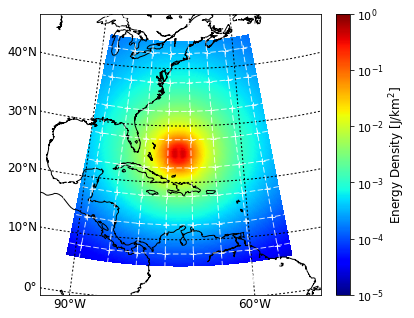

In [152]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 5 
fig_height = 3.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# gs = gridspec.GridSpec(1,2, width_ratios=[1,0.05])

clims = [-5,0]
# fig = plt.figure()
# ax1 = plt.subplot(111)
# ax1 = plt.subplot(gs[0])
# cax = plt.subplot(gs[1])
fig, ax = plt.subplots(1,1)
# m = Basemap(ax,resolution='c',projection='ortho',lat_0 = 20, lon_0 = -70)
h = 10000
# m = Basemap(projection='nsper',satellite_height=h*1000.,\
#         lon_0=-95,lat_0=0,resolution='l',\
#     llcrnrx=0.,llcrnry=0.,urcrnrx=m.urcrnrx/2.,urcrnry=m.urcrnry/2.)
m = Basemap(projection='lcc', lon_0 = -72, lat_0 = 25, width=50*111*1e3, height = 50*111*1e3, resolution='l')

# m = Basemap(llcrnrlon=-100.,llcrnrlat=-10.,urcrnrlon=-20.,urcrnrlat=50.,
#             projection='lcc',lat_1=20.,lat_2=40.,lon_0=-60.,
#             resolution ='l',area_thresh=1000.)
x, y = m(geo_lons, geo_lats)

m.drawcoastlines()
# m.fillcontinents(color='coral',lake_color='aqua', alpha=0.7)
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,10.), labels=[True, False, False, False ])
m.drawmeridians(np.arange(0.,420.,30.), labels = [False, True, False, True])
# m.drawmapboundary(fill_color='grey')


CS1 = m.pcolormesh(x,y,flux,cmap=plt.cm.jet, vmin=clims[0], vmax=clims[1])


px, py = m(grid_lons_geo, grid_lats_geo)

for ind, b in enumerate(glats):
    m.plot(px[ind,:], py[ind,:], '--',marker='+', color='w',linewidth=1, alpha=0.8)

for ind, b in enumerate(glons):
    m.plot(px[:,ind], py[:,ind], '--', color='w',linewidth=1,alpha=0.8)

    

cb = m.colorbar(CS1, location='right', pad="5%")

cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy Density [J/km$^2$]')

# m.drawcoastlines(color='white')
# m.drawmapboundary()
# m.fillcontinents(color='grey',alpha=0.3)
fig.tight_layout()
fig.savefig('input_energy_with_grid.png',dpi=150)


In [135]:
# flux = all_data[i]['pwr']
grid_lons_mag = np.arange(-22.5, 23,5)
grid_lats_mag = np.arange(12.5,58,5)
print in_lats
glons, glats = np.meshgrid(grid_lons_mag, grid_lats_mag)
# flashtime = datetime.datetime(2010,1,4,0,0,0)
tmp_coords = coord.Coords(zip(np.ones_like(glats.ravel()), glats.ravel(), glons.ravel()),'MAG','sph',units=['Re','deg','deg'])
tvec_datetime = [flashtime for s in glats.ravel()]
tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
tmp_coords = tmp_coords.convert('GEO','sph')


grid_lons_geo = tmp_coords.long.reshape(np.shape(glats))
grid_lats_geo = tmp_coords.lati.reshape(np.shape(glats))

ax.scatter(grid_lons_geo, grid_lats_geo)

[ 15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5
  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5  38.5
  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5  50.5
  51.5  52.5  53.5  54.5]


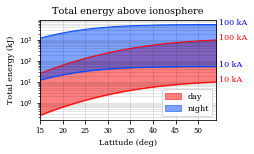

In [54]:
# Do a nice plot -- This one for the ACES 2018 2-page paper. 11.7.2017

import matplotlib.cm as cm

# --------------- Latex Plot Beautification --------------------------
fig_width = 6.5/2.54
fig_height = 3/2.54
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'font.family': 'Serif',
          'axes.labelsize': 8,
          'font.size': 8,
          'legend.fontsize': 8,
          'xtick.labelsize': 7,
          'ytick.labelsize': 7,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

I0vec = np.array([10, 100]) # kA

pwr_day = np.outer(pwr_unscaled[1,:],pow(I0vec*1e3, 2))*1e-3
pwr_nite = np.outer(pwr_unscaled[0,:],pow(I0vec*1e3, 2))*1e-3

fig, ax = plt.subplots(1,1)

# [j.set_linewidth(1.2) for j in ax.spines.itervalues()]  # Thick borders

daycolor = 'red'
nitecolor= cm.jet(50)#'blue'

ax.semilogy(avail_lats, pwr_day, linewidth=1, color=daycolor)
ax.semilogy(avail_lats, pwr_nite, linewidth=1, color=nitecolor)
ax.fill_between(avail_lats, pwr_day[:,0], pwr_day[:,1], color=daycolor, alpha=0.5, zorder=1, label='day')
ax.fill_between(avail_lats, pwr_nite[:,0], pwr_nite[:,1], color=nitecolor, alpha=0.5, zorder=1, label='night')

ax.grid('on', which='both',linestyle='-', color='k', alpha=0.2, linewidth=0.5)
ax.legend()
ax.set_xlim([15,54])
ax.text(avail_lats[-1] + 0.5, pwr_day[-1,1],"100 kA", color='r')
ax.text(avail_lats[-1] + 0.5, pwr_day[-1,0],"10 kA", color='r')
ax.text(avail_lats[-1] + 0.5, pwr_nite[-1,1],"100 kA", color='b')
ax.text(avail_lats[-1] + 0.5, pwr_nite[-1,0],"10 kA", color='b')

ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('Total energy (kJ)')
ax.set_title('Total energy above ionosphere')
fig.tight_layout()
plt.subplots_adjust(right=0.85)

# fig.savefig('total_energy_2col.pdf')



## Below ionosphere plot

In [171]:
# Plot input scaling function (for CEDAR 2016 poster)


R_E = 6378*1e3
H_IONO = 1e5
H_E = 5000.0
Z0 = 377.0
A = 5e3
B = 1e5
D2R = np.pi/180.0

dfreq = 100
dlat = 0.02

freqs = np.linspace(200,60000,512)
lats  = np.linspace(0,15,512)

I0 = -100e3
center_lat = 0

dist_lat =  (R_E + H_IONO/2.0)*abs(center_lat - lats)*D2R    


def input_power_scaling(inp_lat, inp_lon, out_lat, out_lon, w, i0, MLT):
    f = w/(2.0*np.pi);
    D2R = np.pi/180.
    
    Z0 = 377.0
    P_A= 5e3
    P_B= 1e5
    H_E= 5000.0

    H_IONO = 1e5
    R_E = 6371e3
#     flash_loc_sph = xf.c2s(flash_loc)
#     ray_loc_sph   = xf.c2s(ray_loc)
#     out_lat = ray_loc_sph[1]
#     out_lon = ray_loc_sph[2]
#     inp_lat = flash_loc_sph[1]
#     inp_lon = flash_loc_sph[2]
    
    dlat  = D2R*(out_lat - inp_lat)
    dlong = D2R*(out_lon - inp_lon)
    clat1 = np.cos(D2R*inp_lat)
    clat2 = np.cos(D2R*out_lat)
    slat1 = np.sin(D2R*inp_lat)
    slat2 = np.sin(D2R*out_lat)
    # Compute current (latitude and longitude dependent) weighting:
    # (Use Haversine formula since we're moving further out than reasonable for Cartesian)
    a = pow(np.sin(dlat/2.0),2)
    b = (clat1*clat2*pow(np.sin(dlong/2.0),2))
    gc_distance = 2.0*R_E * np.arcsin(np.sqrt(a + b))

    dist_tot= np.hypot(gc_distance, H_IONO)
    xi = np.arctan2(gc_distance, H_IONO)
    
    w_sq =  pow( w , 2 );
    S = ( (1/Z0) * pow( (H_E*i0*2e-7*(np.sin(xi)/dist_tot)*w*(P_A-P_B)) , 2 )
                   /  (  (w_sq+pow(P_A,2))*(w_sq+pow(P_B,2))  )      ) ;
    S_vert = S * np.cos(xi) ;  #// factor for vert prop.

#     // Ionosphere absorption model
#     attn_factor = pow(10,-(graf_iono_model(mag_lat,f, MLT )/10)  );
#     S_vert = S_vert * attn_factor;
#     return S
    return S_vert

In [204]:
scale = np.zeros([len(freqs), len(lats)])

for f_ind, f in enumerate(freqs):
    for lat_ind, lat in enumerate(lats):
        center_lon = 0
        out_lon = 0
        w = 2.*np.pi*f
        MLT = 0
        i0 = -100e3
        scale[f_ind, lat_ind] = input_power_scaling(center_lat, center_lon, lat, out_lon, w, i0, MLT)

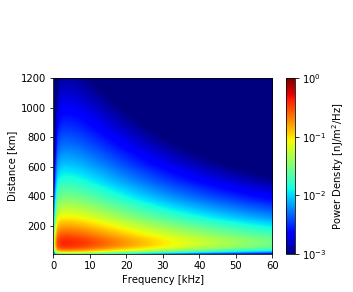

In [205]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 4 
fig_height = 2.25
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'font.family': 'sans-serif',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

scale_scaled = np.log10((1e9)*scale.T)

fig, ax = plt.subplots(1,1)

p1 = ax.pcolorfast(freqs, dist_lat/1000,scale_scaled, cmap = plt.cm.jet, vmin = -3, vmax = 0)

cb = fig.colorbar(p1)
ax.set_xlim([200,60000])
ax.set_ylim([10,1200])

ctix = [-3,-2,-1,0]
cb.set_ticks(ctix)
cb.set_ticklabels(['10$^{%d}$'%c for c in ctix])
cb.set_label('Power Density [nJ/m$^2$/Hz]')

xtix = np.arange(0, 60001,10000)
ax.set_xticks(xtix)
ax.set_xticklabels([x/1000 for x in xtix])
ax.set_xlabel('Frequency [kHz]')
ax.set_ylabel('Distance [km]')

fig.tight_layout()
fig.savefig('power_scaling_below_ionosphere.png',dpi=300)


In [206]:
# Integrate upward-going power to find ratios:
from scipy.integrate import nquad

H_IONO_BOT = 1e5


def integrand(lon, w):
    center_lat = 0
    center_lon = 0
    in_lat = 0
    out_lon = 0
    i0 = -100000
    MLT = 0
    R_E = 6371e3
    p = input_power_scaling(center_lat, center_lon, in_lat, lon, w, i0, MLT)

    return p

opts = dict()
opts['epsabs']= 1.5e-8
opts['epsrel']= 1.5e-8
opts['limit']= 10

ranges = [[0, 90],[200*2.*np.pi, 60000*2.*np.pi]]
integ = nquad(integrand, ranges, opts=opts, full_output=False)
print integ[0]*(R_E + H_IONO_BOT)*D2R*(R_E + H_IONO_BOT)*D2R*2*np.pi * 1e-3


7179.03149008


In [154]:
# Ghetto integrand:

np.shape(scale)

(512, 512)

In [201]:
df = np.diff(freqs)[0]*2.*np.pi
dd = np.diff(dist_lat)[0]

integ = np.sum(np.sum(scale, axis=-1), axis=-1)*df*dd*2*np.pi
print integ

2049.52966696


In [220]:
# total power (not just upgoing):

Zo = 377.
mu = 4.*np.pi*1e-7
a = 5*1e3
b = 1*1e5
H_E = 5000
i0 = -100e3
total_energy = (1/Zo)*pow(mu/2./np.pi, 2)*(pow((a - b),2)/2/(a + b))* (4.*np.pi/3.)*pow(H_E*i0,2)

print "Total energy (before iono or upward)", total_energy*1e-3, "kJ"

Total energy (before iono or upward) 4775.01977999 kJ


total energy from flash: 47.7501977999 kJ
max percentage (day) 5.20306310129 %
max percentage (night) 28.3368122481 %


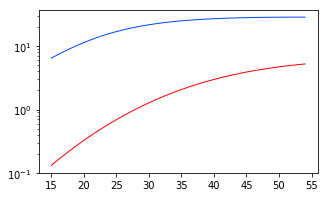

In [241]:
fig, ax = plt.subplots(1,1)

Zo = 377.
mu = 4.*np.pi*1e-7
a = 5*1e3
b = 1*1e5
H_E = 5000
i0 = -10e3
total_energy = (1/Zo)*pow(mu/2./np.pi, 2)*(pow((a - b),2)/2/(a + b))* (4.*np.pi/3.)*pow(H_E*i0,2)*1e-3

print "total energy from flash:",total_energy, "kJ"

pwr_day  = pwr_unscaled[1,:]*pow(i0,2)*1e-3
pwr_nite = pwr_unscaled[0,:]*pow(i0,2)*1e-3

percent_day = (pwr_day/total_energy)*100.
percent_nite =(pwr_nite/total_energy)*100.
daycolor = 'red'
nitecolor= cm.jet(50)#'blue'

ax.semilogy(avail_lats, percent_day, linewidth=1, color=daycolor)
ax.semilogy(avail_lats, percent_nite, linewidth=1, color=nitecolor)

print "max percentage (day)",  np.max(percent_day), "%"
print "max percentage (night)", np.max(percent_nite), "%"


In [264]:
# Load input energies (precalculated)
inlats = [50, 35, 15]
mlts   = [0]
rootdir ='/shared/users/asousa/WIPP/WIPP_stencils/'
power_dir    = os.path.join(rootdir,'outputs','input_energies_0.25deg')

R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.

I0 = 10000.
all_data = []
for inlat in inlats:
    for mlt in [0, 12]:
        fn = os.path.join(power_dir,'input_energy_%d_%d.pklz'%(inlat, mlt))
#         print os.path.exists(fn)
        print fn
        with gzip.open(fn,'rb') as file:
            data = pickle.load(file)
        
        
        # Get areas of each cell (for energy density)
        
        areas = np.zeros([len(data['clats']), len(data['clons'])])
        
        
        dlat = data['clats'][1] - data['clats'][0]
        dlon = data['clons'][1] - data['clons'][0] 
        
        # Get areas of each cell, in km:
        cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos(data['clats']*D2R))
        
        # Sum over frequencies:
        data['pwr'] = np.sum(data['pwr'], axis=0)
        data['pwr']*= pow(I0,2)  # scale by peak current
#         data['pwr']/= cell_areas[:, np.newaxis] # Divide by area to get density
        data['pwr'] = np.hstack([np.fliplr(data['pwr'][:,:-1]), data['pwr']]) # Flip for both sides of flash
        
        x = data['clons']
        data['clons'] = np.hstack([x[:-1] - x[-1] + x[0], x])
#         print np.shape(data['clons'])
#         print np.shape(data['clats'])
#         print np.shape(data['pwr'])
        all_data.append(data)


/shared/users/asousa/WIPP/WIPP_stencils/outputs/input_energies_0.25deg/input_energy_50_0.pklz
/shared/users/asousa/WIPP/WIPP_stencils/outputs/input_energies_0.25deg/input_energy_50_12.pklz
/shared/users/asousa/WIPP/WIPP_stencils/outputs/input_energies_0.25deg/input_energy_35_0.pklz
/shared/users/asousa/WIPP/WIPP_stencils/outputs/input_energies_0.25deg/input_energy_35_12.pklz
/shared/users/asousa/WIPP/WIPP_stencils/outputs/input_energies_0.25deg/input_energy_15_0.pklz
/shared/users/asousa/WIPP/WIPP_stencils/outputs/input_energies_0.25deg/input_energy_15_12.pklz


In [266]:
data = all_data[0]

p = np.sum(np.sum(data['pwr']))

print p*1e-3

107.906497376
